In [138]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM , Dropout

This is the final data preprocessing step in order to actually train the LSTM Model required for forecasting. For the model we have to predict dengue cases of T+8 time interval which is 8 weeks in advance. If we look at the data we see that the large cycles of dengue fluctuations around every 6 months and we use that as the lookback period. This means that to make a prediction for T+8, we have to use data from T-17 to T.

In [139]:
df = pd.read_csv("Processed_Data.csv",index_col = 0)
df.fillna(160,inplace = True)
train = df[:"2019"]
test = df["2019":]

#Min-Max feature scaling to restrict all inputs to between 0 and 1 so that the algorithm can learn well
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
train = sc.fit_transform(train)


In [166]:
max_lookback = 35
pred_interval = 8 
input_len = max_lookback - pred_interval
X_train =[]
y_train = [] 
for i in range(len(train)-max_lookback):
    X_train.append(train[i:i+max_lookback-pred_interval])
    y_train.append(train[i+max_lookback,2])
X_train, y_train = np.array(X_train),np.array(y_train)

Now X_train is a 340 x 18 x 3 tensor while y_train is a 1D vector which corresponds to the correc T + 18 prediction. The model input for the prediction will be a 18 x 3 matrix which corresponds to 18 weeks of data from T-17 to T and the data having 3 indicators, rainfall, temperature and dengue infections

In [170]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],3)))
'''model.add(LSTM(units = 50, return_sequences = True)) 
model.add(LSTM(units = 50, return_sequences = True))'''
model.add(LSTM(units = 50))
model.add(Dense(1)) # No Activation because it is a regressor - you dont want your output to between 0 and 1
model.compile(optimizer = "adam",loss = "mean_squared_error")
model.fit(X_train,y_train,epochs =250,batch_size=32,workers = 12, max_queue_size = 150)

Epoch 1/250
331/331 [==============================] - 2s 6ms/step - loss: 0.0544
Epoch 2/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 3/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 4/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0308
Epoch 5/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 6/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 7/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 8/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0275
Epoch 9/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 10/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 11/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 12/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0246
Epoch 13/250


331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 99/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 100/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 101/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 102/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 103/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 104/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0020A: 0s - loss: 0.
Epoch 105/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 106/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 107/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 108/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 109/250
331/331 [==============================] - 0s 1ms/step - loss

331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 195/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 196/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 197/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 198/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 199/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 200/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 201/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 202/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 203/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 204/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 205/250
331/331 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 

In [171]:
#Preprocessing of X_test to do a preliminary cross-validation
inputs = df.iloc[len(df) - len(test) - input_len:]
inputs = sc.transform(inputs)
X_test = []
for i in range(len(inputs) - input_len):
    X_test.append(inputs[i:i+input_len])
X_test= np.array(X_test)
pred = model.predict(X_test)
pred = np.concatenate([np.zeros((pred.shape[0],2)),pred],axis = 1)
results = sc.inverse_transform(pred)

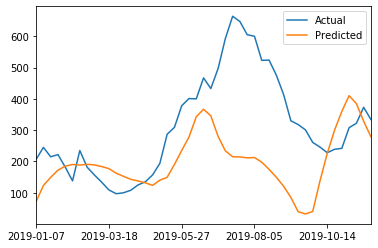

In [172]:
vis = pd.DataFrame([test["dengue"].values,results[:,2]])
vis = vis.T
vis.columns = ["Actual","Predicted"]
vis.index = test.index
vis.plot()

In [129]:
vis

,Actual,Predicted
2019-01-07,207.0,193.765001
2019-01-14,245.0,191.488360
2019-01-21,215.0,255.200581
2019-01-28,222.0,243.315774
2019-02-04,182.0,261.480216
2019-02-11,138.0,233.900545
2019-02-18,235.0,189.976995
2019-02-25,182.0,229.372328
2019-03-04,157.0,223.510425
2019-03-11,134.0,224.123834


In [118]:
results[:,2]

array([193.7650006 , 191.48836036, 255.20058051, 243.31577432,
       261.48021626, 233.9005453 , 189.97699526, 229.37232828,
       223.51042539, 224.12383407, 216.73205271, 218.2455495 ,
       214.5813628 , 214.31238283, 213.70720375, 216.70439248,
       224.30737866, 228.77563718, 230.57364294, 235.40975288,
       243.7984913 , 249.15599862, 254.12409219, 254.54771626,
       260.95179078, 273.47421643, 279.81080049, 285.57074422,
       290.74787217, 300.83345819, 289.26799142, 254.4776161 ,
       225.04299107, 210.02323759, 210.4124317 , 209.37340938,
       211.72580843, 200.26289512, 198.53267696, 219.26479237,
       230.55784263, 234.98800211, 235.39510238, 259.44395265,
       278.82485068, 286.30998695, 322.69300273])

In [106]:
model.save("datathon.h5")

,Average Rain,Avg Temp,dengue
2019-01-07,1.581454,28.737083,207.0
2019-01-14,3.845125,28.175000,245.0
2019-01-21,8.060479,27.513929,215.0
2019-01-28,0.191828,27.508818,222.0
2019-02-04,1.364418,28.082993,182.0
2019-02-11,0.848188,28.168155,138.0
2019-02-18,3.308387,28.039702,235.0
2019-02-25,1.979330,28.254286,182.0
2019-03-04,1.037436,28.252500,157.0
2019-03-11,5.236384,28.647500,134.0


In [132]:
X_train.shape

(314, 44, 3)